# 1. Descarga y exploración del corpus
En este primer ejercicio se procede a la descarga de los corpus a estudiar y su posterior analisis exploratorio.

#Librerias y descarga de archivos

## Librerias

In [1]:
!pip install stop_words

  Preparing metadata (setup.py) ... done
  Created wheel for stop_words: filename=stop_words-2018.7.23-py3-none-any.whl size=32895 sha256=b816eb6c38d80dc80c6e1a80c7878bae8e4325c336cff15691d8e9c5e5616e20
  Stored in directory: /root/.cache/pip/wheels/d0/1a/23/f12552a50cb09bcc1694a5ebb6c2cd5f2a0311de2b8c3d9a89
Successfully built stop_words


In [2]:
import os
import json
import gzip
from urllib.request import urlopen
import matplotlib.pyplot as plt

from collections import Counter # Exploración
from nltk import ngrams # Exploración
from nltk.probability import FreqDist # Exploración
import unicodedata # Preprocesado
import re # Preprocesado
from stop_words import get_stop_words # Preprocesado
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from wordcloud import WordCloud

pd.set_option('display.max_rows', None) # para mostrar todas las filas
pd.set_option('display.max_columns', None) # para mostrar todas las columnas
pd.set_option('max_colwidth', None) #para mostrar todo el contenido de la columnas
pd.set_option('display.width',3000)

In [3]:
# Montamos / conectamso con google drive.
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Descarga de datos

In [4]:
!wget http://snap.stanford.edu/data/amazon/productGraph/categoryFiles/reviews_Video_Games_5.json.gz

--2024-03-29 17:19:54--  http://snap.stanford.edu/data/amazon/productGraph/categoryFiles/reviews_Video_Games_5.json.gz
Resolving snap.stanford.edu (snap.stanford.edu)... 171.64.75.80
Connecting to snap.stanford.edu (snap.stanford.edu)|171.64.75.80|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 113104579 (108M) [application/x-gzip]
Saving to: ‘reviews_Video_Games_5.json.gz’

reviews_Video_Games 100%[===================>] 107.86M  31.1MB/s    in 6.3s    

2024-03-29 17:20:00 (17.2 MB/s) - ‘reviews_Video_Games_5.json.gz’ saved [113104579/113104579]



In [5]:
### load the meta data
data = []
with gzip.open('reviews_Video_Games_5.json.gz') as f:
    for l in f:
        data.append(json.loads(l.strip()))

# total length of list, this number equals total number of products
print(len(data))

# first row of the list
print(data[0])

231780
{'reviewerID': 'A2HD75EMZR8QLN', 'asin': '0700099867', 'reviewerName': '123', 'helpful': [8, 12], 'reviewText': 'Installing the game was a struggle (because of games for windows live bugs).Some championship races and cars can only be "unlocked" by buying them as an addon to the game. I paid nearly 30 dollars when the game was new. I don\'t like the idea that I have to keep paying to keep playing.I noticed no improvement in the physics or graphics compared to Dirt 2.I tossed it in the garbage and vowed never to buy another codemasters game. I\'m really tired of arcade style rally/racing games anyway.I\'ll continue to get my fix from Richard Burns Rally, and you should to. :)http://www.amazon.com/Richard-Burns-Rally-PC/dp/B000C97156/ref=sr_1_1?ie=UTF8&qid;=1341886844&sr;=8-1&keywords;=richard+burns+rallyThank you for reading my review! If you enjoyed it, be sure to rate it as helpful.', 'overall': 1.0, 'summary': "Pay to unlock content? I don't think so.", 'unixReviewTime': 134179

In [6]:
# convert list into pandas dataframe
df = pd.DataFrame.from_dict(data)
print(len(df))

231780


# Revisión preexploratoria

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 231780 entries, 0 to 231779
Data columns (total 9 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   reviewerID      231780 non-null  object 
 1   asin            231780 non-null  object 
 2   reviewerName    228967 non-null  object 
 3   helpful         231780 non-null  object 
 4   reviewText      231780 non-null  object 
 5   overall         231780 non-null  float64
 6   summary         231780 non-null  object 
 7   unixReviewTime  231780 non-null  int64  
 8   reviewTime      231780 non-null  object 
dtypes: float64(1), int64(1), object(7)
memory usage: 15.9+ MB


In [8]:
#Nos quedamos con las columnas overall y la review ('reviewText)
df = df[['overall','reviewText']]
df = df.astype({'overall':'int'})

Analizamos que puntación tienen y su opinion

In [9]:
df.head(5)

,overall,reviewText
0,1,"Installing the game was a struggle (because of games for windows live bugs).Some championship races and cars can only be ""unlocked"" by buying them as an addon to the game. I paid nearly 30 dollars when the game was new. I don't like the idea that I have to keep paying to keep playing.I noticed no improvement in the physics or graphics compared to Dirt 2.I tossed it in the garbage and vowed never to buy another codemasters game. I'm really tired of arcade style rally/racing games anyway.I'll continue to get my fix from Richard Burns Rally, and you should to. :)http://www.amazon.com/Richard-Burns-Rally-PC/dp/B000C97156/ref=sr_1_1?ie=UTF8&qid;=1341886844&sr;=8-1&keywords;=richard+burns+rallyThank you for reading my review! If you enjoyed it, be sure to rate it as helpful."
1,4,If you like rally cars get this game you will have fun.It is more oriented to &#34;European market&#34; since here in America there isn't a huge rally fan party. Music it is very European and even the voices from the game very &#34;English&#34; accent.The multiplayer isn't the best but it works just ok.
2,1,1st shipment received a book instead of the game.2nd shipment got a FAKE one. Game arrived with a wrong key inside on sealed box. I got in contact with codemasters and send them pictures of the DVD and the content. They said nothing they can do its a fake DVD.Returned it good bye.!
3,3,"I got this version instead of the PS3 version, which turned out to be a mistake. Console versions of games look 95 percent as good as their PC versions, but you do not have to deal with driver issues and the numerous things that can go wrong with windows. First off the installation takes about 30 minutes, which is ridiculous. I have never had a game take this long to load, Shift 2 took about 20 minutes which seemed too long also. Next many of the latest games for PC are forcing you to have an internet connection in order to install the game, regardless of whether you want to play only offline single player games. Shift 2 unleashed is also like this, so be forewarned. Internet requirements are not prominently displayed on the boxes. The game pushes you, but does not require you to, sign up for a Games For Windows Live account, which is required to get the game patches and updates. More time wasted signing up for that. Finally after about one hour the game was up and running , but the menu screen text had red blocky borders, and the sun in the game screens was ugly pink red, with red reflections on the car and everywhere. So more time spent googling to find a solution to this. I had to download a hot-fix driver update for my AMD videocard driver, which solved that red text and sun problem. Finally after nearly 2 hours I was able to play the game, which is perhaps the prettiest racing game I have ever played. Magnificent graphics, and fun excellent gameplay. Good forcefeedback effects with a steering wheel, and excellent sense of speed and immersion, makes this a top notch sim racer with just a hint of arcade feeling to it.I was really, finally enjoying the game , when suddenly about 30 minutes in to a race the game suddenly crashed. No error message or anything, it just hung up and crashed to desktop, under windows 7. I later tried it with Windows XP on the same machine, and it crashed less frequently, usually only when exiting the game, but random crashes really kill the fun of a racing game, since it might not crash during an entire 20 lap race or it might crash on the 2nd lap.It is a great game when it works, and if you are lucky enough to have a machine that it runs stably on then by all means get this game. But hang on to your receipt just in case.I am tired of fiddling with my computer trying to find a totally reliable setup for this game, so I think I am going to buy a copy for my PS3, which has never crashed, in over 3 years of game playing. I have been buying the top notch PC versions of videogames and spent thousands of dollars over the 

Revisamos que no haya nulos y vemos su tamaño

In [11]:
#df['reviewText'].isnull().sum()
df['overall'].isnull().sum()

0

In [12]:
len(df)

231780

# Analisis exploratorio Corpus

## Cardinalidad del vocabularios

Vamos a revisar la cardinalidad del corpus, para así ver el tamaño del vocabulario que se va utilizar, viendo asi su complejidad. Sacamos una muestra de las opiniones ya que en otras pruebas se me bloqueaba el colab y prefiero menor resultado a poder desarrollarlo correctamente.

In [10]:
extract_pd = df.sample(frac=0.05, random_state=42)

Convertimos todo en minusculas y lo dividimos en palabras individuales, y luego contabilizamos.

In [11]:
splitted_reviews = extract_pd['reviewText'].str.lower().str.split()
words = splitted_reviews.apply(pd.Series).stack().reset_index(drop = True)
vocabulary_ = Counter(words)

<ipython-input-11-1e3a1a9f0412>:2: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  words = splitted_reviews.apply(pd.Series).stack().reset_index(drop = True)


In [12]:
print(f"Las reviews del DF estan formadas por {len(vocabulary_)} palabras.")

Las reviews del DF estan formadas por 121623 palabras.


Distribucion reviews por estrellas

In [16]:
extract_pd['overall'].value_counts()

5    6046
4    2687
3    1461
1     727
2     668
Name: overall, dtype: int64

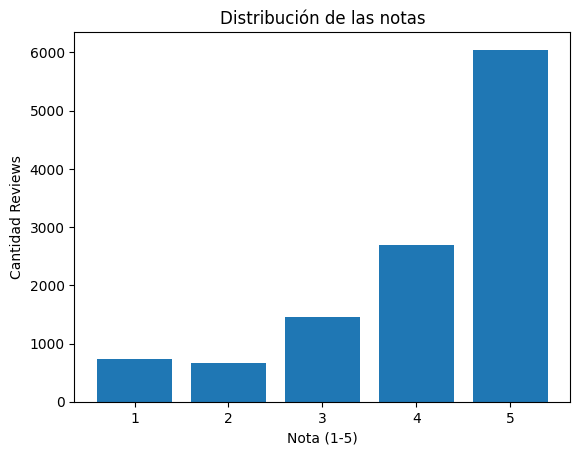

In [13]:
# Contar las puntuaciones y crear un gráfico de barras
puntuacion_counts = extract_pd['overall'].value_counts()

plt.bar(puntuacion_counts.index, puntuacion_counts.values)
plt.xlabel('Nota (1-5)')
plt.ylabel('Cantidad Reviews')
plt.title('Distribución de las notas')
plt.show()

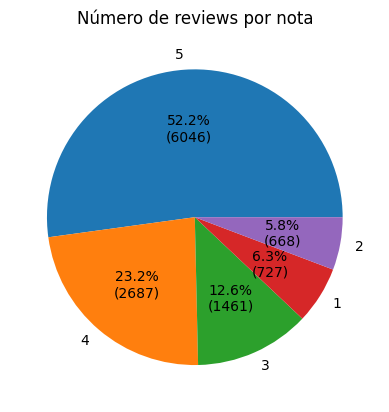

In [14]:
def autopct_format(values):
        def my_format(pct):
            total = sum(values)
            val = int(round(pct*total/100.0))
            return '{:.1f}%\n({v:d})'.format(pct, v=val)
        return my_format

fig, ax = plt.subplots()
ax.set_title('Número de reviews por nota')
ax.pie(puntuacion_counts,labels = puntuacion_counts.index, autopct=autopct_format(puntuacion_counts));

# Distribución de positivas y negarivas

Analizamos las distribuciones, si la nota < que 3 será negativa y si es > 3 será positiva.

In [19]:
extract_pd['reviewbinary'] = [ 0 if s <=3 else 1 for s in extract_pd['overall']]

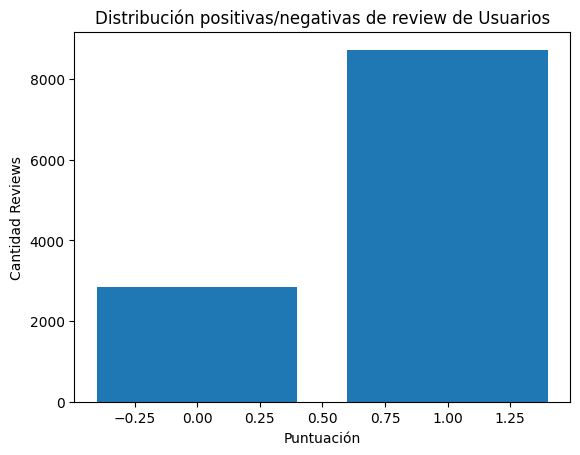

In [20]:
# Contar las puntuaciones y crear un gráfico de barras
puntuacion_counts = extract_pd['reviewbinary'].value_counts()

plt.bar(puntuacion_counts.index, puntuacion_counts.values)
plt.xlabel('Puntuación')
plt.ylabel('Cantidad Reviews')
plt.title('Distribución positivas/negativas de review de Usuarios')
plt.show()

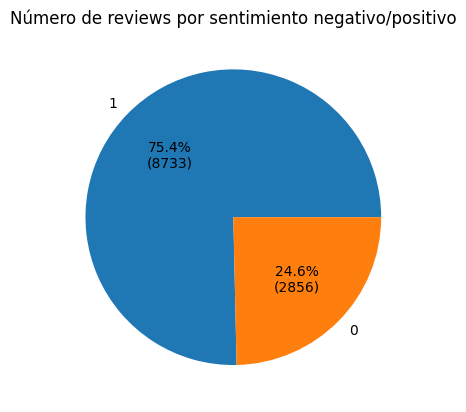

In [21]:
def autopct_format(values):
        def my_format(pct):
            total = sum(values)
            val = int(round(pct*total/100.0))
            return '{:.1f}%\n({v:d})'.format(pct, v=val)
        return my_format

fig, ax = plt.subplots()
ax.set_title('Número de reviews por sentimiento negativo/positivo')
ax.pie(puntuacion_counts,labels = puntuacion_counts.index, autopct=autopct_format(puntuacion_counts));

# N gramas

Vamos a ver los N-gramas para ver la frecuencia con la que se utilizan las palabras ya sea unigramas, bigramas o trigama...

In [22]:
wf_most_common = vocabulary_.most_common(10)

In [23]:
wf_most_common

[('the', 127097),
 ('and', 65057),
 ('to', 62062),
 ('a', 58953),
 ('of', 46328),
 ('i', 41641),
 ('is', 41572),
 ('you', 39589),
 ('it', 31406),
 ('this', 29362)]

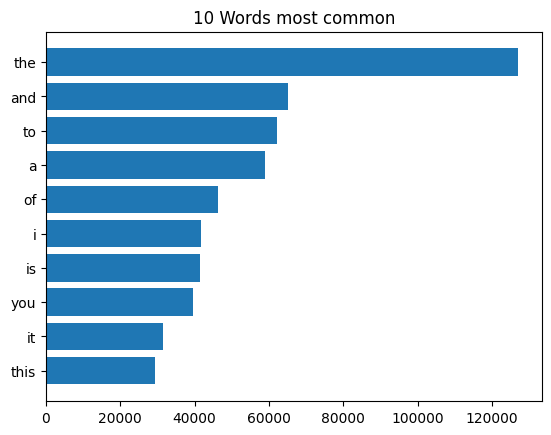

In [24]:
words_1_gram = [w[0] for w in wf_most_common]
freqs_1_gram = [w[1] for w in wf_most_common]
freqs_1_gram, words_1_gram = zip(*sorted(zip(freqs_1_gram, words_1_gram)))
plt.title("10 Words most common")
plt.barh(words_1_gram, freqs_1_gram)
plt.show()

In [25]:
bigrams_ = ngrams(words, 2)
trigrams_ = ngrams(words, 3)

In [26]:
bigrams_freq_ = FreqDist(bigrams_)
trigrams_freq_ = FreqDist(trigrams_)

In [27]:
bigrams_freq_.most_common(10)

[(('of', 'the'), 12648),
 (('the', 'game'), 9116),
 (('this', 'game'), 8627),
 (('in', 'the'), 7301),
 (('is', 'a'), 5753),
 (('if', 'you'), 5568),
 (('you', 'can'), 5445),
 (('to', 'the'), 5261),
 (('on', 'the'), 4757),
 (('and', 'the'), 4691)]

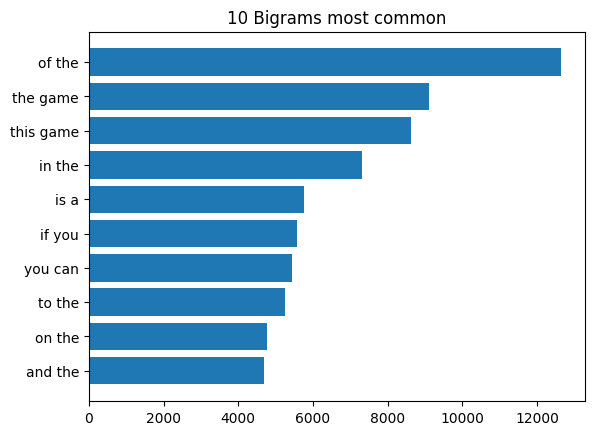

In [28]:
words_1_gram = [" ".join(map(str, w1)) for w1,w2 in bigrams_freq_.most_common(10)]
freqs_1_gram = [w2 for w1,w2 in bigrams_freq_.most_common(10)]
freqs_1_gram, words_1_gram = zip(*sorted(zip(freqs_1_gram, words_1_gram)))
plt.title("10 Bigrams most common")
plt.barh(words_1_gram, freqs_1_gram)
plt.show()

In [29]:
trigrams_freq_.most_common(10)

[(('this', 'game', 'is'), 2348),
 (('a', 'lot', 'of'), 1781),
 (('the', 'game', 'is'), 1551),
 (('one', 'of', 'the'), 1485),
 (('this', 'is', 'a'), 1250),
 (('you', 'have', 'to'), 1206),
 (('of', 'the', 'game'), 988),
 (('some', 'of', 'the'), 975),
 (('the', 'graphics', 'are'), 732),
 (('if', 'you', 'are'), 695)]

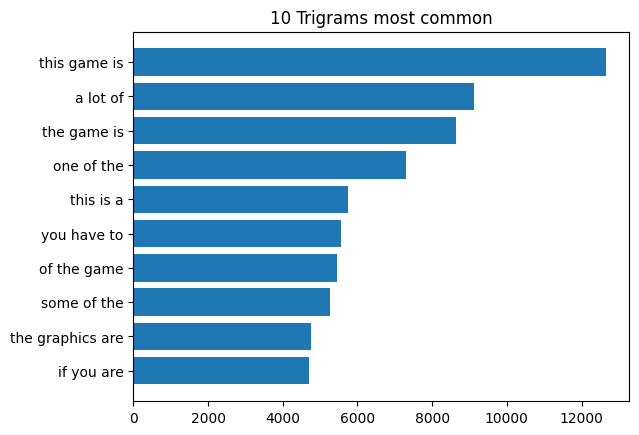

In [30]:
words_1_gram = [" ".join(map(str, w1)) for w1,w2 in trigrams_freq_.most_common(10)]
freqs_1_gram = [w2 for w1,w2 in bigrams_freq_.most_common(10)]
freqs_1_gram, words_1_gram = zip(*sorted(zip(freqs_1_gram, words_1_gram)))
plt.title("10 Trigrams most common")
plt.barh(words_1_gram, freqs_1_gram)
plt.show()

# Nubes de palabras

Vamos a generar los word clouds para ver la representación de la frecuencia o importancia de las palabras del DF.

In [31]:
def plot_word_cloud(text):
    wordcloud = WordCloud(max_font_size=50, max_words=60, background_color="white").generate(' '.join(text))
    plt.figure(figsize=(12,6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()

<ipython-input-32-6732c46ad84b>:2: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  words_pos = pos.apply(pd.Series).stack().reset_index(drop = True)


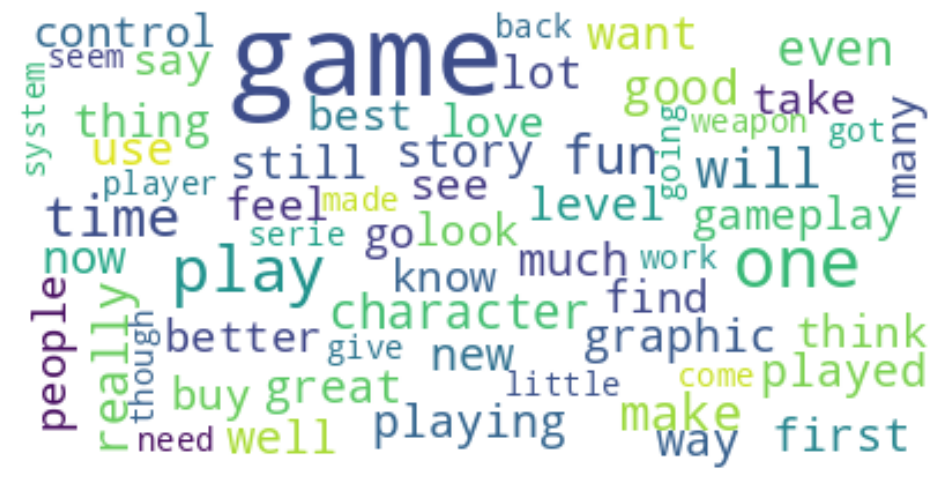

In [32]:
pos = extract_pd['reviewText'].str.lower().str.split()
words_pos = pos.apply(pd.Series).stack().reset_index(drop = True)
plot_word_cloud(words_pos)

<ipython-input-33-b02c7d7e917a>:3: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  words_pos = pos.apply(pd.Series).stack().reset_index(drop = True)


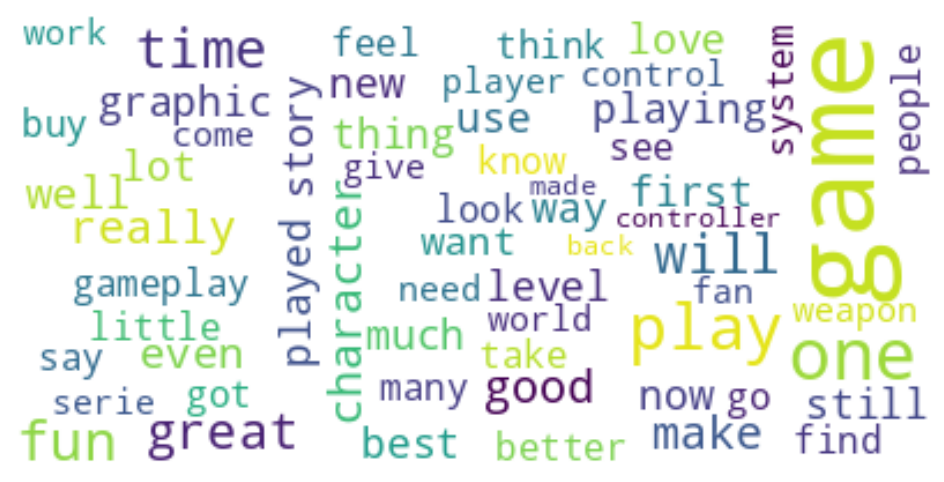

In [33]:
df_pos = extract_pd[extract_pd['overall']==5]
pos = df_pos['reviewText'].str.lower().str.split()
words_pos = pos.apply(pd.Series).stack().reset_index(drop = True)
plot_word_cloud(words_pos)

<ipython-input-34-63cfd7f68f68>:3: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  words_neg = neg.apply(pd.Series).stack().reset_index(drop = True)


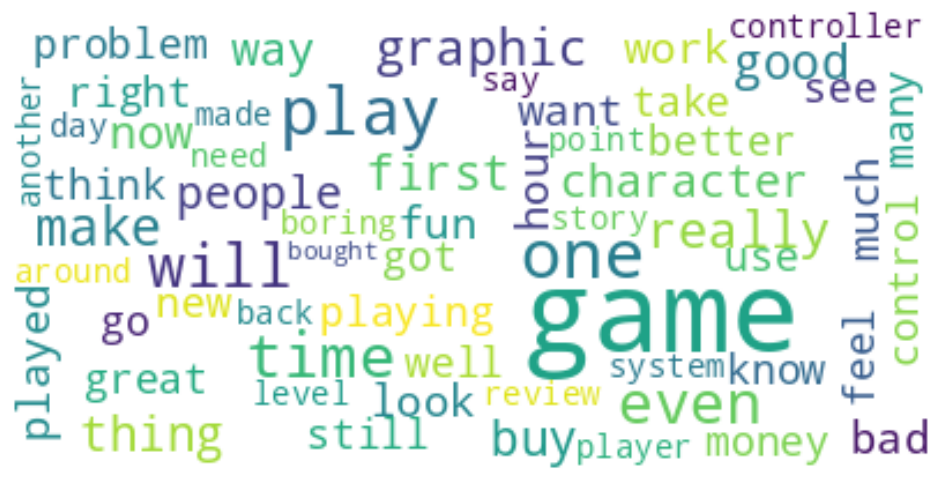

In [34]:
df_neg = extract_pd[extract_pd['overall']==1]
neg = df_neg['reviewText'].str.lower().str.split()
words_neg = neg.apply(pd.Series).stack().reset_index(drop = True)
plot_word_cloud(words_neg)

#Pipeline

Ahora vanis a transformar el texto en cruzo de una forma que podamos realizar el analisis de datos NLP, preprocesando y tokenizando.

In [35]:
!pip install num2words

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.3/143.3 kB 1.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for docopt: filename=docopt-0.6.2-py2.py3-none-any.whl size=13706 sha256=916462d6fb0988a76e7f43ab91f01d795f22100b971223c6eeb86a5933c1c836
  Stored in directory: /root/.cache/pip/wheels/fc/ab/d4/5da2067ac95b36618c629a5f93f809425700506f72c9732fac
Successfully built docopt


In [36]:
import unicodedata
from num2words import num2words

from nltk import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

import nltk
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords

tokenizer = RegexpTokenizer(r'\w+')
sw_list = stopwords.words('english')
lemmatizer = WordNetLemmatizer()

def nltk_cleaner(text, tokenizer = tokenizer, sw_list = sw_list, lemmatizer = lemmatizer):
    clean_text = list()

    # Eliminar acentos, etc
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')

    # Separar palabras eliminando signos de puntuación
    for word in tokenizer.tokenize(text):

        # Eliminar stop words
        if word not in sw_list:

        # Eliminar espacios sobrantes, convertir a minúsculas y lematizar
            clean_word = lemmatizer.lemmatize(word).lower().strip()

        # Convertir dígitos a palabras
            if clean_word.isdigit():
                clean_word = num2words(clean_word, lang='en')

            clean_text.append(clean_word)

    return ' '.join(clean_text)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [37]:
extract_pd.head()

overall  \
168500        5   
189019        4   
94086         3   
168763        4   
17314         5   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     

In [38]:
# Crear la nueva columna 'preprocesado'
extract_pd['nltk'] =  extract_pd['reviewText'].apply(nltk_cleaner)

In [39]:
extract_pd.head()

overall  \
168500        5   
189019        4   
94086         3   
168763        4   
17314         5   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     

#Visualización en 2 dimensiones de algunos word embeddings calculados con Word2Vec (elegir 4-5 palabras y pintar las top 10 más similares)

In [40]:
from gensim.models import FastText
from gensim.models.word2vec import LineSentence
from gensim.models.phrases import Phrases, Phraser
import numpy as np
from sklearn.manifold import TSNE
from gensim.models import Word2Vec
from gensim.models.word2vec import LineSentence

In [41]:
sent = [row.split() for row in extract_pd['nltk']]

In [42]:
sg_params = {
    'sg': 1,
    'vector_size': 75,
    'min_count': 5,
    'window': 5,
    'hs': 0,
    'negative': 20,
    'workers': 4,
    'min_n': 3,
    'max_n': 6
}


In [43]:
ft_sg = FastText(**sg_params)

In [44]:
# Skip Gram
ft_sg.build_vocab(sent)

In [45]:
print('Vocabulario compuesto por {} palabras'.format(len(ft_sg.wv.key_to_index  )))

Vocabulario compuesto por 11866 palabras


In [46]:
ft_sg.train(corpus_iterable=sent, total_examples=len(sent), epochs=10)

(11625969, 13555890)

In [47]:
ft_sg.save('./w2v_model_fast.pkl')

In [48]:
w2v_sg = Word2Vec.load('./w2v_model_fast.pkl')

In [49]:
keys = ['good','waste','fun','boring']

embedding_clusters = []
word_clusters = []
for word in keys:
    embeddings = []
    words = []
    for similar_word, _ in w2v_sg.wv.most_similar(word, topn=10):
        words.append(similar_word)
        embeddings.append(w2v_sg.wv[similar_word])
    embedding_clusters.append(embeddings)
    word_clusters.append(words)

In [50]:
tsne_model_2d = TSNE(perplexity=15, n_components=2, init='pca', n_iter=3500, random_state=32)

In [51]:
embedding_clusters = np.array(embedding_clusters)
n, m, k = embedding_clusters.shape

In [52]:
embeddings_2d = np.array(tsne_model_2d.fit_transform(embedding_clusters.reshape(n * m, k))).reshape(n, m, 2)

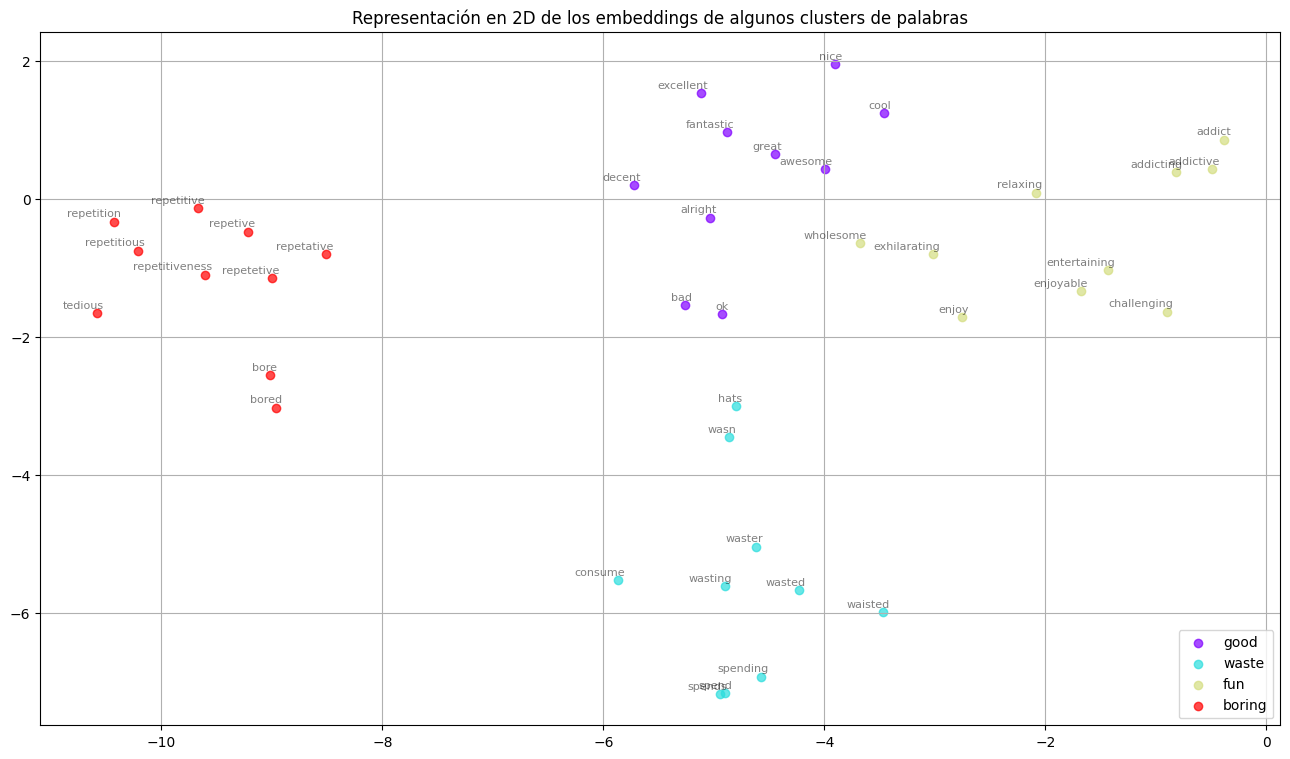

In [53]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
%matplotlib inline


def tsne_plot_similar_words(labels, embedding_clusters, word_clusters, a=0.7):
    plt.figure(figsize=(16, 9))
    colors = cm.rainbow(np.linspace(0, 1, len(labels)))
    for label, embeddings, words, color in zip(labels, embedding_clusters, word_clusters, colors):
        x = embeddings[:,0]
        y = embeddings[:,1]
        plt.scatter(x, y, c=[color], alpha=a, label=label)
        for i, word in enumerate(words):
            plt.annotate(word, alpha=0.5, xy=(x[i], y[i]), xytext=(5, 2),
                         textcoords='offset points', ha='right', va='bottom', size=8)
    plt.legend(loc=4)
    plt.grid(True)
    plt.title('Representación en 2D de los embeddings de algunos clusters de palabras')
    # plt.savefig("f/г.png", format='png', dpi=150, bbox_inches='tight')
    plt.show()


tsne_plot_similar_words(keys, embeddings_2d, word_clusters)



# Ley de ZIPF

In [54]:
import matplotlib.pyplot as plt
from nltk.probability import FreqDist

In [55]:
splitted_reviews = extract_pd['nltk'].str.lower().str.split()
words_zipf = splitted_reviews.apply(pd.Series).stack().reset_index(drop = True)

<ipython-input-55-b3dfe51b49d3>:2: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  words_zipf = splitted_reviews.apply(pd.Series).stack().reset_index(drop = True)


In [56]:
fd = FreqDist(words_zipf)

In [57]:
fd = {k: v for k, v in sorted(fd.items(), key=lambda item: item[1], reverse=True)}

In [58]:
ranks = list()
freqs = list()

for rank, word in enumerate(fd):
    ranks.append(rank+1)
    freqs.append(fd[word])

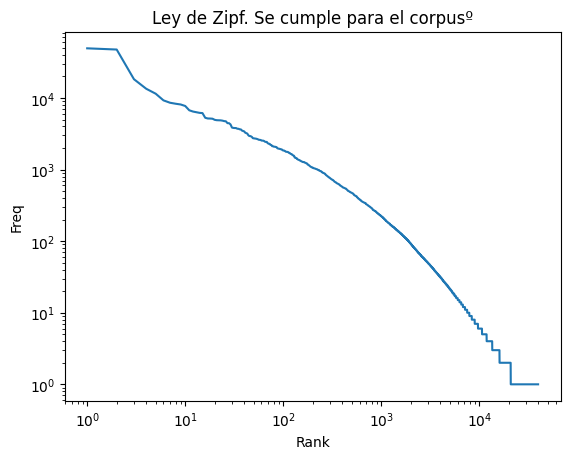

In [59]:
plt.loglog(ranks, freqs)
plt.xlabel('Rank')
plt.ylabel('Freq')
plt.title('Ley de Zipf. Se cumple para el corpusº')
plt.show()

Al cumplirse la Ley de Zipf, se da que la distribucióin de frecuencias de palabras en el corpus sigue un patron predecible, donde unas pocas palabras son extremadamente comunes y muchas son raras.

# Palabras por review

In [60]:
# Función para contar palabras en un texto
def contar_palabras(texto):
  if pd.isna(texto):
    return 0
  return len(texto.split())

# Crear la nueva columna 'palabras_en_review'
extract_pd['word_count'] =  extract_pd['reviewText'].apply(contar_palabras)

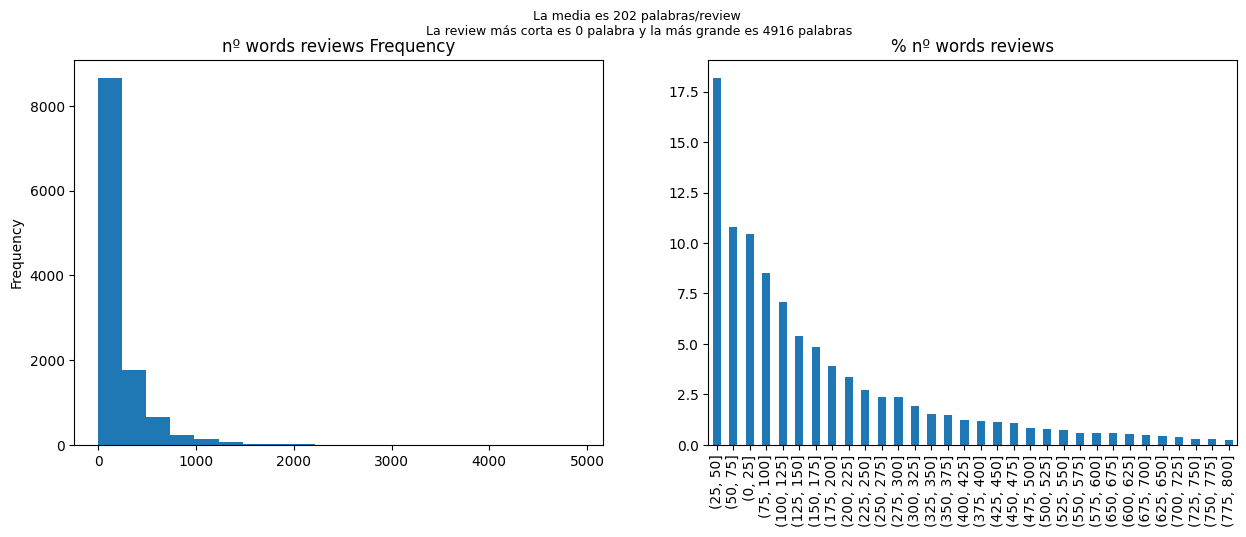

In [61]:
review_media = round(sum(extract_pd['word_count'])/len(extract_pd))
review_small = min(extract_pd['word_count'])
review_large = max(extract_pd['word_count'])
plt.figure(figsize=(15,5))
plt.subplot(1,2, 1)
extract_pd['word_count'].plot.hist(title='nº words reviews Frequency',bins=20)
plt.subplot(1,2, 2)
(100 * pd.cut(extract_pd['word_count'], bins=[x for x in range(0, 801, 25)]).value_counts() / len(extract_pd['word_count'])).plot(kind='bar', title='% nº words reviews')
plt.suptitle(f" La media es {review_media} palabras/review \n La review más corta es {review_small} palabra y la más grande es {review_large} palabras", fontsize=9,y=0.98)
plt.show()

In [62]:
#Media de palabras por sentimiento
print("Las reviews con notas más bajas de 4 tienen mayor media de palabras que las review más positivas \n")
extract_pd.groupby("overall")["word_count"].mean().head(5)

Las reviews con notas más bajas de 4 tienen mayor media de palabras que las review más positivas 



overall
1    173.314993
2    251.634731
3    241.878850
4    251.040566
5    168.022990
Name: word_count, dtype: float64

# FInal eda

In [63]:
df.head()

,overall,reviewText
0,1,"Installing the game was a struggle (because of games for windows live bugs).Some championship races and cars can only be ""unlocked"" by buying them as an addon to the game. I paid nearly 30 dollars when the game was new. I don't like the idea that I have to keep paying to keep playing.I noticed no improvement in the physics or graphics compared to Dirt 2.I tossed it in the garbage and vowed never to buy another codemasters game. I'm really tired of arcade style rally/racing games anyway.I'll continue to get my fix from Richard Burns Rally, and you should to. :)http://www.amazon.com/Richard-Burns-Rally-PC/dp/B000C97156/ref=sr_1_1?ie=UTF8&qid;=1341886844&sr;=8-1&keywords;=richard+burns+rallyThank you for reading my review! If you enjoyed it, be sure to rate it as helpful."
1,4,If you like rally cars get this game you will have fun.It is more oriented to &#34;European market&#34; since here in America there isn't a huge rally fan party. Music it is very European and even the voices from the game very &#34;English&#34; accent.The multiplayer isn't the best but it works just ok.
2,1,1st shipment received a book instead of the game.2nd shipment got a FAKE one. Game arrived with a wrong key inside on sealed box. I got in contact with codemasters and send them pictures of the DVD and the content. They said nothing they can do its a fake DVD.Returned it good bye.!
3,3,"I got this version instead of the PS3 version, which turned out to be a mistake. Console versions of games look 95 percent as good as their PC versions, but you do not have to deal with driver issues and the numerous things that can go wrong with windows. First off the installation takes about 30 minutes, which is ridiculous. I have never had a game take this long to load, Shift 2 took about 20 minutes which seemed too long also. Next many of the latest games for PC are forcing you to have an internet connection in order to install the game, regardless of whether you want to play only offline single player games. Shift 2 unleashed is also like this, so be forewarned. Internet requirements are not prominently displayed on the boxes. The game pushes you, but does not require you to, sign up for a Games For Windows Live account, which is required to get the game patches and updates. More time wasted signing up for that. Finally after about one hour the game was up and running , but the menu screen text had red blocky borders, and the sun in the game screens was ugly pink red, with red reflections on the car and everywhere. So more time spent googling to find a solution to this. I had to download a hot-fix driver update for my AMD videocard driver, which solved that red text and sun problem. Finally after nearly 2 hours I was able to play the game, which is perhaps the prettiest racing game I have ever played. Magnificent graphics, and fun excellent gameplay. Good forcefeedback effects with a steering wheel, and excellent sense of speed and immersion, makes this a top notch sim racer with just a hint of arcade feeling to it.I was really, finally enjoying the game , when suddenly about 30 minutes in to a race the game suddenly crashed. No error message or anything, it just hung up and crashed to desktop, under windows 7. I later tried it with Windows XP on the same machine, and it crashed less frequently, usually only when exiting the game, but random crashes really kill the fun of a racing game, since it might not crash during an entire 20 lap race or it might crash on the 2nd lap.It is a great game when it works, and if you are lucky enough to have a machine that it runs stably on then by all means get this game. But hang on to your receipt just in case.I am tired of fiddling with my computer trying to find a totally reliable setup for this game, so I think I am going to buy a copy for my PS3, which has never crashed, in over 3 years of game playing. I have been buying the top notch PC versions of videogames and spent thousands of dollars over the 

Rebalanceamos y evitar el desequilibrio de las clases, muestreamos aleatoriamente

In [65]:
num_samples = 10000

sampled_df_1 = df[df['overall'] == 1].sample(n=num_samples)
sampled_df_2 = df[df['overall'] == 2].sample(n=num_samples)
sampled_df_3 = df[df['overall'] == 3].sample(n=num_samples)
sampled_df_4 = df[df['overall'] == 4].sample(n=num_samples)
sampled_df_5 = df[df['overall'] == 5].sample(n=num_samples)


result_df = pd.concat([sampled_df_1,sampled_df_2,sampled_df_3,sampled_df_4,sampled_df_5])

result_df.to_csv('reviews_large.csv', sep=';', decimal='.', index=False)